# Numerical Differentiation for Data Preprocessing & Data Science  
### Forward / Backward / Central Differences + Euler Method (with Real-World Exercises)

This notebook is designed for a **Numerical Optimization: Precourse of Numerical Differentiation** course.

**Goal:** show how numerical differentiation is a *practical preprocessing tool* used to:
- estimate velocity/acceleration from sensor data,
- compute trends and slopes (features) for ML,
- detect anomalies (sudden changes),
- connect discrete data to differential equations (Euler method).

We will cover:
1. Forward / Backward / Central differences
2. Error and step size intuition
3. Real-world-style example: wearable heart-rate / activity signal
4. Feature engineering for ML (slope, acceleration, change-point)
5. Euler method: from derivative to simulation (ODE)
6. Exercises 


## 0. Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=6, suppress=True)

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return np.sqrt(np.mean((y_true - y_pred)**2))


## 1. Why numerical differentiation?

In many real datasets we observe a signal $x(t)$ at discrete times:
- temperature each hour
- heart rate each minute
- stock price each day
- platelet count each day (healthcare)
- traffic volume each hour (telecom)

But we often need the **rate of change**:
$$
\frac{dx}{dt}
$$

Examples:
- speed from position (physics, GPS)
- slope/trend as ML features
- detect sudden changes (anomalies)
- estimate gradients in optimization


## 2. Finite difference formulas

Assume uniform step size $h$ and samples $x_k = x(t_k)$ with $t_k = t_0 + kh$.

### Forward difference (uses future point)
$$
x'(t_k) \approx \frac{x_{k+1} - x_k}{h}
$$

### Backward difference (uses past point)
$$
x'(t_k) \approx \frac{x_k - x_{k-1}}{h}
$$

### Central difference (uses both sides, more accurate)
$$
x'(t_k) \approx \frac{x_{k+1} - x_{k-1}}{2h}
$$

**Accuracy (informal):**
- Forward/backward: error is $O(h)$
- Central: error is $O(h^2)$ (usually better)


In [2]:
def diff_forward(x, h=1.0):
    x = np.asarray(x, dtype=float)
    d = (x[1:] - x[:-1]) / h
    return np.concatenate([d, [d[-1]]])  # pad last

def diff_backward(x, h=1.0):
    x = np.asarray(x, dtype=float)
    d = (x[1:] - x[:-1]) / h
    return np.concatenate([[d[0]], d])   # pad first

def diff_central(x, h=1.0):
    x = np.asarray(x, dtype=float)
    d = np.empty_like(x, dtype=float)
    d[0]  = (x[1] - x[0]) / h
    d[-1] = (x[-1] - x[-2]) / h
    d[1:-1] = (x[2:] - x[:-2]) / (2*h)
    return d


## 3. Sanity check on a known function

Let $x(t)=\sin(t)$. True derivative is $x'(t)=\cos(t)$.
We compare forward/backward/central and see which is closer.


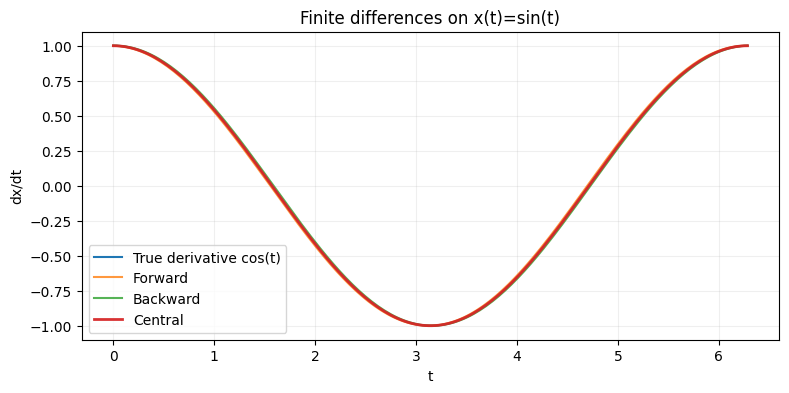

RMSE forward : 0.0111347777802414
RMSE backward: 0.011134777780241396
RMSE central : 0.00011777380844206332


In [3]:
t = np.linspace(0, 2*np.pi, 200)
h = t[1] - t[0]
x = np.sin(t)
dx_true = np.cos(t)

dx_f = diff_forward(x, h)
dx_b = diff_backward(x, h)
dx_c = diff_central(x, h)

plt.figure(figsize=(9,4))
plt.plot(t, dx_true, label="True derivative cos(t)")
plt.plot(t, dx_f, label="Forward", alpha=0.8)
plt.plot(t, dx_b, label="Backward", alpha=0.8)
plt.plot(t, dx_c, label="Central", alpha=0.95, linewidth=2)
plt.xlabel("t")
plt.ylabel("dx/dt")
plt.title("Finite differences on x(t)=sin(t)")
plt.grid(True, alpha=0.2)
plt.legend()
plt.show()

print("RMSE forward :", rmse(dx_true, dx_f))
print("RMSE backward:", rmse(dx_true, dx_b))
print("RMSE central :", rmse(dx_true, dx_c))


## 4. Real-world preprocessing example: wearable heart-rate signal

A wearable device records heart rate (HR) every minute.  
We want to:
- compute slope $dHR/dt$,
- detect sudden jumps (artifact),
- create ML features (slope, acceleration, rolling stats).

We simulate:
- baseline around 75 bpm,
- increase during activity,
- recovery,
- noise + an injected spike artifact.


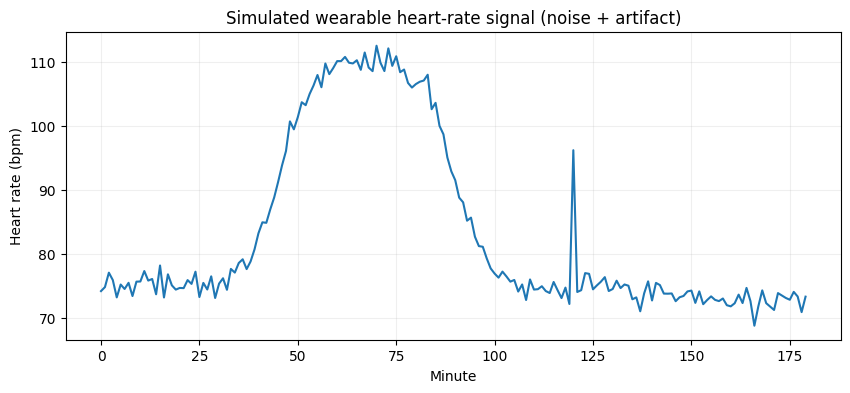

In [4]:
rng = np.random.default_rng(4)

minutes = np.arange(0, 180)   # 3 hours
h = 1.0                       # 1 minute sampling

HR = 75 + 0.5*np.sin(2*np.pi*minutes/60)
# activity from minute 40 to 90 (smooth rise and fall)
HR += 35 * (1/(1+np.exp(-(minutes-45)/4)) - 1/(1+np.exp(-(minutes-90)/4)))
# recovery trend
HR += -0.03*np.maximum(0, minutes-95)

HR += rng.normal(0, 1.2, size=len(minutes))  # noise

HR[120] += 20  # artifact spike

plt.figure(figsize=(10,4))
plt.plot(minutes, HR)
plt.xlabel("Minute")
plt.ylabel("Heart rate (bpm)")
plt.title("Simulated wearable heart-rate signal (noise + artifact)")
plt.grid(True, alpha=0.2)
plt.show()


## 5. First derivative (slope) and second derivative (acceleration)

- Slope: $dHR/dt$
- Acceleration: $d^2HR/dt^2$ (differentiate the slope)

In practice:
- slope helps detect *activity onset*
- acceleration helps detect *rapid changes / spikes*


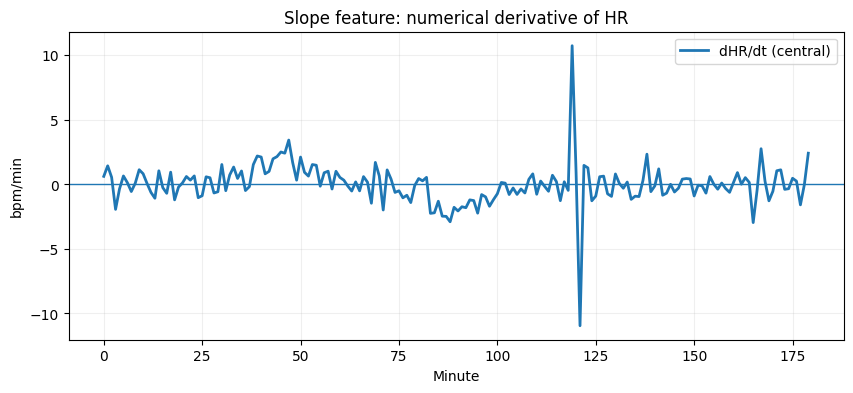

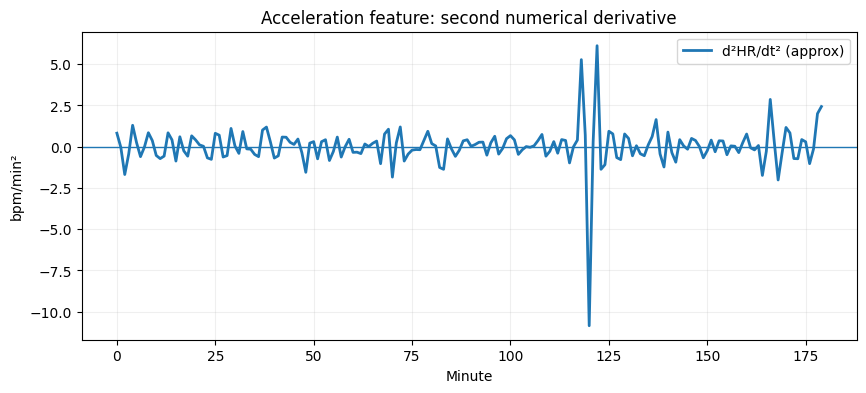

In [5]:
dHR_f = diff_forward(HR, h)
dHR_b = diff_backward(HR, h)
dHR_c = diff_central(HR, h)

ddHR = diff_central(dHR_c, h)  # second derivative approx

plt.figure(figsize=(10,4))
plt.plot(minutes, dHR_c, label="dHR/dt (central)", linewidth=2)
plt.axhline(0, linewidth=1)
plt.xlabel("Minute")
plt.ylabel("bpm/min")
plt.title("Slope feature: numerical derivative of HR")
plt.grid(True, alpha=0.2)
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(minutes, ddHR, label="d²HR/dt² (approx)", linewidth=2)
plt.axhline(0, linewidth=1)
plt.xlabel("Minute")
plt.ylabel("bpm/min²")
plt.title("Acceleration feature: second numerical derivative")
plt.grid(True, alpha=0.2)
plt.legend()
plt.show()


## 6. Anomaly detection using derivatives (simple baseline)

A spike often creates:
- large $|dHR/dt|$
- large $|d^2HR/dt^2|$

We detect anomaly points by thresholding:
$$
|dHR/dt| > \tau_1 \quad \text{or} \quad |d^2HR/dt^2| > \tau_2
$$


## 7. Feature engineering for ML (build a feature matrix)

We create features per time step:
- HR
- slope $dHR/dt$
- acceleration $d^2HR/dt^2$
- rolling mean / rolling std
- absolute slope

These features can feed a classifier (artifact vs normal) or activity detection model.


In [7]:
def rolling_mean(x, w):
    x = np.asarray(x, dtype=float)
    out = np.empty_like(x)
    for i in range(len(x)):
        a = max(0, i-w+1)
        out[i] = x[a:i+1].mean()
    return out

def rolling_std(x, w):
    x = np.asarray(x, dtype=float)
    out = np.empty_like(x)
    for i in range(len(x)):
        a = max(0, i-w+1)
        out[i] = x[a:i+1].std(ddof=0)
    return out

w = 10
HR_mean = rolling_mean(HR, w)
HR_std  = rolling_std(HR, w)

X = np.column_stack([HR, dHR_c, ddHR, HR_mean, HR_std, np.abs(dHR_c)])
feature_names = ["HR", "dHR_dt", "ddHR_dt2", "HR_roll_mean", "HR_roll_std", "|dHR_dt|"]

print("X shape:", X.shape)
print("Example feature row at minute 50:")
print({feature_names[j]: float(X[50,j]) for j in range(len(feature_names))})


X shape: (180, 6)
Example feature row at minute 50:
{'HR': 101.42442427338231, 'dHR_dt': 2.1187477937477794, 'ddHR_dt2': 0.304029609685049, 'HR_roll_mean': 92.87829437836014, 'HR_roll_std': 6.084793244727106, '|dHR_dt|': 2.1187477937477794}


## 8. Euler method (numerical integration): from derivative to simulation

ODE form:
$$
\frac{dx}{dt} = f(t, x)
$$

Euler update:
$$
x_{k+1} = x_k + h f(t_k, x_k)
$$

### Real-world: cooling dynamics
Newton's law of cooling:
$$
\frac{dT}{dt} = -k(T - T_{env})
$$


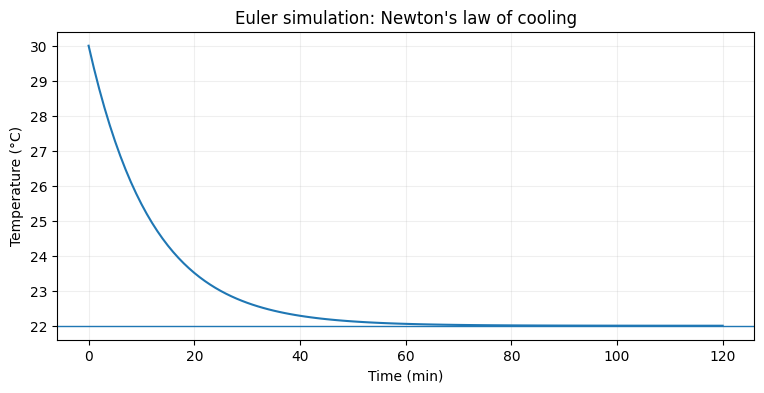

In [8]:
def euler(f, t0, x0, h, n_steps):
    t = np.zeros(n_steps+1)
    x = np.zeros(n_steps+1)
    t[0] = t0
    x[0] = x0
    for k in range(n_steps):
        x[k+1] = x[k] + h*f(t[k], x[k])
        t[k+1] = t[k] + h
    return t, x

k = 0.08
T_env = 22.0
T0 = 30.0

def f_cool(t, T):
    return -k*(T - T_env)

t_sim, T_sim = euler(f_cool, t0=0.0, x0=T0, h=1.0, n_steps=120)

plt.figure(figsize=(9,4))
plt.plot(t_sim, T_sim)
plt.axhline(T_env, linewidth=1)
plt.xlabel("Time (min)")
plt.ylabel("Temperature (°C)")
plt.title("Euler simulation: Newton's law of cooling")
plt.grid(True, alpha=0.2)
plt.show()


## 9. Optimization link (simple setpoint choice)

We choose a setpoint $s$ to balance comfort and energy:
$$
J(s) = \sum_k \max(0, T_k - s)^2 + \lambda (s - s_{min})^2
$$

We solve it with grid search (easy to teach).


In [ ]:
def cost_setpoint(T, s, lam=0.05, s_min=20.0):
    return np.sum(np.maximum(0, T - s)**2) + lam*(s - s_min)**2

s_grid = np.linspace(18, 28, 401)
J = np.array([cost_setpoint(T_sim, s) for s in s_grid])
s_star = s_grid[np.argmin(J)]

plt.figure(figsize=(8,4))
plt.plot(s_grid, J)
plt.axvline(s_star, linestyle="--", linewidth=1)
plt.xlabel("Setpoint s (°C)")
plt.ylabel("Cost J(s)")
plt.title(f"Best setpoint ≈ {s_star:.2f} °C")
plt.grid(True, alpha=0.2)
plt.show()

print("Optimal setpoint:", s_star)


## 10. Exercises (with solutions)

### Exercise 1 — Differences on noisy data
Create $x(t)=\sin(t)+\epsilon$ and compare forward vs central.

✅ Solution below.


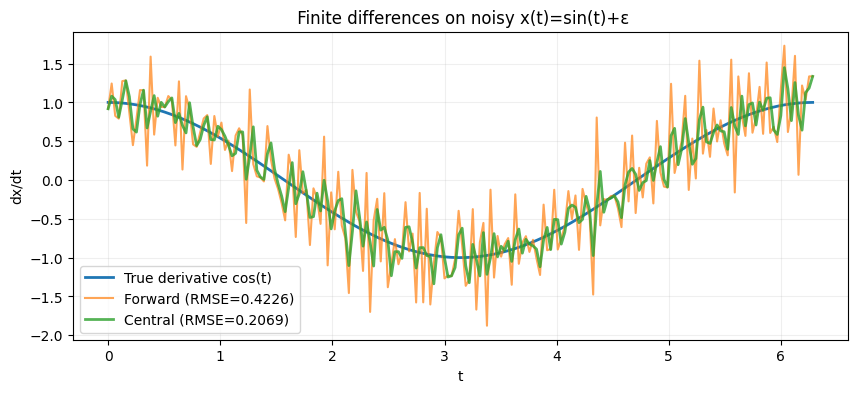

Forward difference RMSE: 0.422623
Central difference RMSE: 0.206874
Central is 2.04x better than forward on noisy data


In [20]:
rng = np.random.default_rng(0)
t = np.linspace(0, 2*np.pi, 200)
h = t[1] - t[0]
x = np.sin(t) + 0.01 * np.random.normal(0, 1, size=len(t))

# noise
epsilon = rng.normal(0, 0.01, size=len(t))  # noise
x = np.sin(t) + epsilon
dx_true = np.cos(t)

# To compute finite differences
dx_f = diff_forward(x, h)
dx_c = diff_central(x, h)

# here we are trying to compare
rmse_f = rmse(dx_true, dx_f)
rmse_c = rmse(dx_true, dx_c)

plt.figure(figsize=(10, 4))
plt.plot(t, dx_true, label="True derivative cos(t)", linewidth=2)
plt.plot(t, dx_f, label=f"Forward (RMSE={rmse_f:.4f})", alpha=0.7)
plt.plot(t, dx_c, label=f"Central (RMSE={rmse_c:.4f})", alpha=0.8, linewidth=2)
plt.xlabel("t")
plt.ylabel("dx/dt")
plt.title(" Finite differences on noisy x(t)=sin(t)+ε")
plt.grid(True, alpha=0.2)
plt.legend()
plt.show()

print(f"Forward difference RMSE: {rmse_f:.6f}")
print(f"Central difference RMSE: {rmse_c:.6f}")
print(f"Central is {rmse_f/rmse_c:.2f}x better than forward on noisy data")

### Exercise 2 — Spike detection
Inject a spike in HR and detect it with $|dHR/dt|$ threshold.

✅ Solution below.


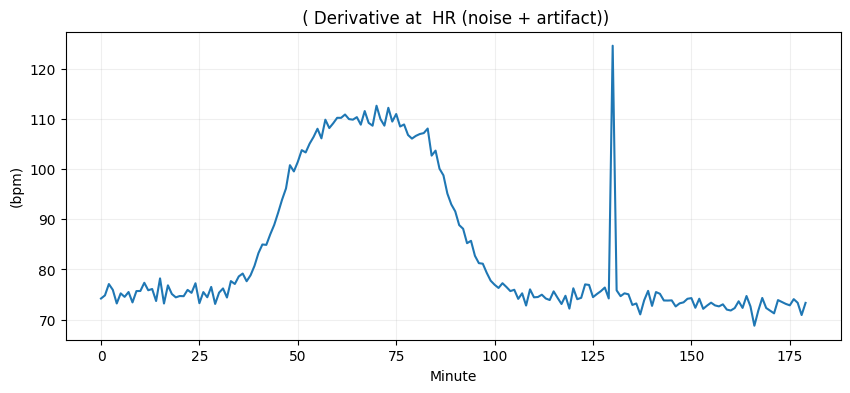

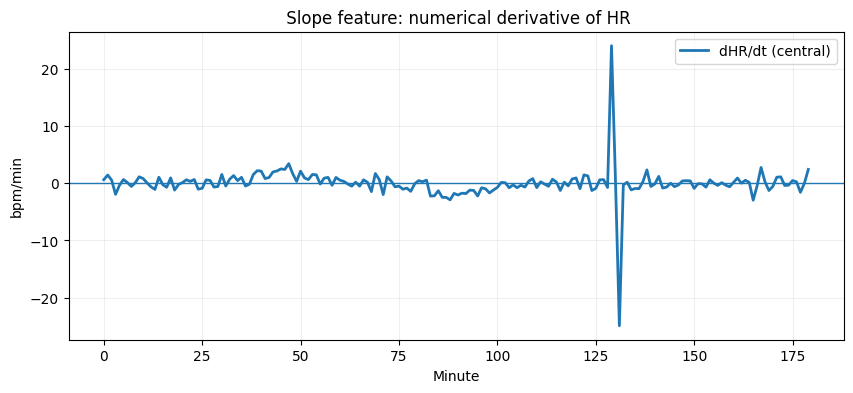

In [26]:
rng = np.random.default_rng(4)

minutes = np.arange(0, 180)   # 3 hours
h = 1.0                       # 1 minute sampling

HR = 75 + 0.5*np.sin(2*np.pi*minutes/60)
# activity from minute 40 to 90 (smooth rise and fall)
HR += 35 * (1/(1+np.exp(-(minutes-45)/4)) - 1/(1+np.exp(-(minutes-90)/4)))
# recovery trend
HR += -0.03*np.maximum(0, minutes-95)

HR += rng.normal(0, 1.2, size=len(minutes))  # noise

HR[130] += 50  # artifact spike

plt.figure(figsize=(10,4))
plt.plot(minutes, HR)
plt.xlabel("Minute")
plt.ylabel("(bpm)")
plt.title(" ( Derivative at  HR (noise + artifact))")
plt.grid(True, alpha=0.2)
plt.show()


dHR_f = diff_forward(HR, h)
dHR_c = diff_central(HR, h) 
ddHR = diff_central(dHR_c, h)  # second derivative approx
plt.figure(figsize=(10,4))
plt.plot(minutes, dHR_c, label="dHR/dt (central)", linewidth=2)
plt.axhline(0, linewidth=1)
plt.xlabel("Minute")
plt.ylabel("bpm/min")
plt.title(" Slope feature: numerical derivative of HR")
plt.grid(True, alpha=0.2)
plt.legend()

### Exercise 3 — Euler step size
Simulate cooling with $h=1$, $h=5$, $h=15$ minutes and compare.

✅ Solution below.


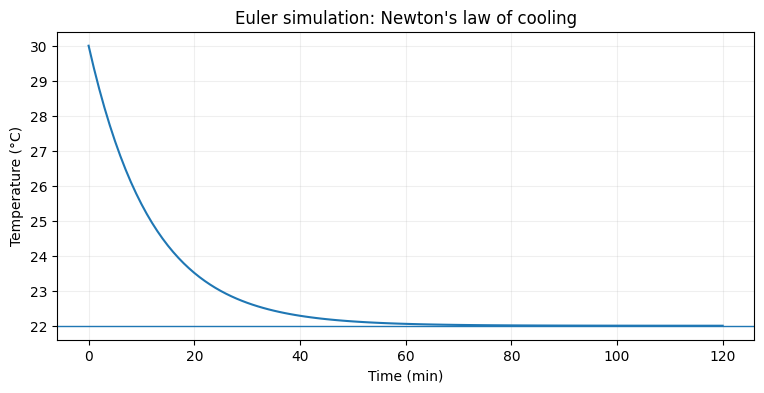

In [29]:
def euler(f, t0, x0, h, n_steps):
    t = np.zeros(n_steps+1)
    x = np.zeros(n_steps+1)
    t[0] = t0
    x[0] = x0
    for k in range(n_steps):
        x[k+1] = x[k] + h*f(t[k], x[k])
        t[k+1] = t[k] + h
    return t, x

k = 0.08
T_env = 22.0
T0 = 30.0

def f_cool(t, T):
    return -k*(T - T_env)

t_sim, T_sim = euler(f_cool, t0=0.0, x0=T0, h=1.0, n_steps=120)

plt.figure(figsize=(9,4))
plt.plot(t_sim, T_sim)
plt.axhline(T_env, linewidth=1)
plt.xlabel("Time (min)")
plt.ylabel("Temperature (°C)")
plt.title("Euler simulation: Newton's law of cooling")
plt.grid(True, alpha=0.2)
plt.show()


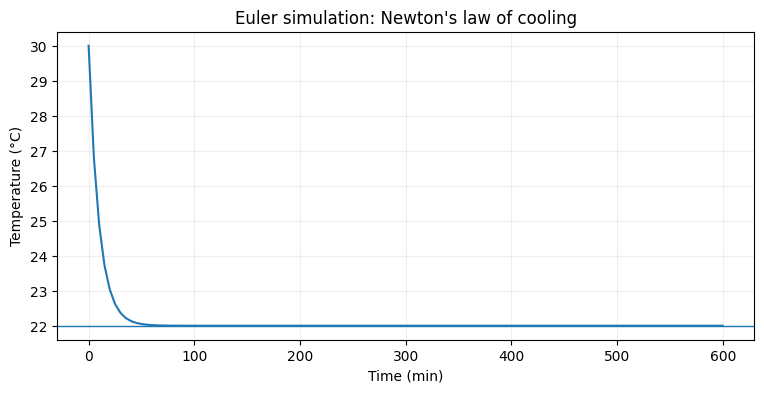

In [30]:
def euler(f, t0, x0, h, n_steps):
    t = np.zeros(n_steps+1)
    x = np.zeros(n_steps+1)
    t[0] = t0
    x[0] = x0
    for k in range(n_steps):
        x[k+1] = x[k] + h*f(t[k], x[k])
        t[k+1] = t[k] + h
    return t, x

k = 0.08
T_env = 22.0
T0 = 30.0

def f_cool(t, T):
    return -k*(T - T_env)

t_sim, T_sim = euler(f_cool, t0=0.0, x0=T0, h=5.0, n_steps=120)

plt.figure(figsize=(9,4))
plt.plot(t_sim, T_sim)
plt.axhline(T_env, linewidth=1)
plt.xlabel("Time (min)")
plt.ylabel("Temperature (°C)")
plt.title("Euler simulation: Newton's law of cooling")
plt.grid(True, alpha=0.2)
plt.show()


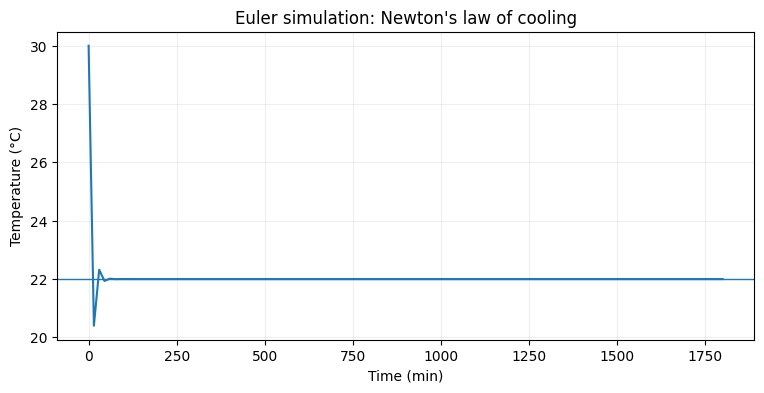

In [31]:
def euler(f, t0, x0, h, n_steps):
    t = np.zeros(n_steps+1)
    x = np.zeros(n_steps+1)
    t[0] = t0
    x[0] = x0
    for k in range(n_steps):
        x[k+1] = x[k] + h*f(t[k], x[k])
        t[k+1] = t[k] + h
    return t, x

k = 0.08
T_env = 22.0
T0 = 30.0

def f_cool(t, T):
    return -k*(T - T_env)

t_sim, T_sim = euler(f_cool, t0=0.0, x0=T0, h=15.0, n_steps=120)

plt.figure(figsize=(9,4))
plt.plot(t_sim, T_sim)
plt.axhline(T_env, linewidth=1)
plt.xlabel("Time (min)")
plt.ylabel("Temperature (°C)")
plt.title("Euler simulation: Newton's law of cooling")
plt.grid(True, alpha=0.2)
plt.show()


## 11. Takeaways

- Finite differences approximate derivatives from discrete data.
- Central difference is often more accurate than forward/backward.
- Derivatives are powerful preprocessing features: slope, acceleration, change detection.
- Euler method connects derivatives to simulation (ODEs).
- Numerical differentiation can approximate gradients for optimization when needed.
